In [71]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Utils

In [72]:
def show(image):
    
    plt.figure()
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        img2 = image[:,:,::-1]
        plt.imshow(img2)

In [73]:
# Fonction pour redimensionner une image pour une taille cible
def resize_image(image, target_size):
    # Récupérer la hauteur et la largeur de l'image d'origine
    height, width = image.shape[:2]

    # Redimensionner l'image en conservant le rapport d'aspect
    if height > width:
        new_height = target_size
        new_width = int(width * (target_size / height))
    else:
        new_width = target_size
        new_height = int(height * (target_size / width))

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    return resized_image

In [74]:
import math

def overlap_percentage(circle1, circle2):
    # Coordonnées et rayons des cercles
    x1, y1 = circle1[0]
    x2, y2 = circle2[0]
    r1 = circle1[1]
    r2 = circle2[1]

    # Calcul de la distance entre les centres des cercles
    distance_centers = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Si les cercles ne se chevauchent pas du tout
    if distance_centers >= r1 + r2:
        return 0.0

    # Si l'un des cercles est entièrement contenu dans l'autre
    if distance_centers + min(r1, r2) <= max(r1, r2):
        return 100.0

    # Calcul de la zone d'intersection
    intersection_area = (r1**2 * math.acos((distance_centers**2 + r1**2 - r2**2) / (2 * distance_centers * r1)) +
                          r2**2 * math.acos((distance_centers**2 + r2**2 - r1**2) / (2 * distance_centers * r2)) -
                          0.5 * math.sqrt((-distance_centers + r1 + r2) * (distance_centers + r1 - r2) * (distance_centers - r1 + r2) * (distance_centers + r1 + r2)))

    # Calcul de la zone totale des deux cercles
    total_area = math.pi * r2**2

    # Calcul du pourcentage d'overlap
    overlap_percent = (intersection_area / total_area) * 100

    return overlap_percent

# Définir une fonction pour traiter les cercles qui se chevauchent
def process_overlapping_circles(circles):
    i=0
    # Parcourir tous les cercles
    while i < len(circles):
        # Parcourir tous les autres cercles
        j = 0
        while j < len(circles) and i < len(circles):
            if i ==j:
              j+=1
              continue
            # Calculer le pourcentage de chevauchement entre les cercles
            percentage = overlap_percentage(circles[i], circles[j])
            # Si le pourcentage de chevauchement est supérieur à 60%
            if percentage >= 60:
                # Supprimer le cercle j
                del circles[j]
                # Décrémenter j pour ajuster l'indice après la suppression
                j -= 1
            # Si le pourcentage de chevauchement est supérieur à 35%
            elif percentage >= 35:
                # Étendre le cercle i pour couvrir le cercle j
                circles[i] = ((circles[i][0][0], circles[i][0][1]), circles[i][1] + circles[j][1])

                # Supprimer le cercle j
                del circles[j]
                # Décrémenter j pour ajuster l'indice après la suppression
                j -= 1
            j+=1
        i+=1

In [75]:
import json

def calculate_circle_metrics(x1, y1, r1, x2, y2, r2, img_shape):
    # Créez des images vides pour les deux cercles, avec un seul canal
    circle1_img = np.zeros((img_shape[0], img_shape[1], 1), dtype=np.uint8)
    circle2_img = np.zeros((img_shape[0], img_shape[1], 1), dtype=np.uint8)
    
    # Dessinez les cercles sur les images
    cv2.circle(circle1_img, (int(x1), int(y1)), int(r1), 255, -1)
    cv2.circle(circle2_img, (int(x2), int(y2)), int(r2), 255, -1)
    
    # Trouvez les pixels en commun
    intersection = cv2.bitwise_and(circle1_img, circle2_img)

    # Compter les pixels dans chaque catégorie
    circle1_count = cv2.countNonZero(circle1_img)
    circle2_count = cv2.countNonZero(circle2_img)
    tp = cv2.countNonZero(intersection)
    fp = circle1_count - tp
    fn = circle2_count - tp
    
    return tp, fp, fn

def get_json_circles(json_path,image_resized,image):
    # Chargez les cercles à partir du fichier JSON
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)

    # Extraire les cercles du fichier JSON
    json_circles = []
    for shape in data["shapes"]:
        if shape["shape_type"] == "circle":
            x1, y1 = shape["points"][0]
            x2, y2 = shape["points"][1]
            # Ajuster les coordonnées x, y du JSON en fonction de la nouvelle taille de l'image
            x1 = x1 * image_resized.shape[1] / image.shape[1]
            y1 = y1 * image_resized.shape[0] / image.shape[0]
            x2 = x2 * image_resized.shape[1] / image.shape[1]
            y2 = y2 * image_resized.shape[0] / image.shape[0]
            
            radius = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

            json_circles.append((x1, y1, radius,shape["label"]))
    return json_circles

def get_value_with_label(label):
    dico = {"AUTRE":0,"1c":1,"2c":2,"5c":5,"10c":10,"20c":20,"50c":50,"1e":100,"2e":200}
    return dico[label]

def get_category_with_label(label):
    dico = {"AUTRE":"a","1c":"r","2c":"r","5c":"r","10c":"y","20c":"y","50c":"y","1e":"g1","2e":"g2"}
    return dico[label]

def get_json_value(json_path):
    # Chargez les cercles à partir du fichier JSON
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)

    # Extraire les cercles du fichier JSON
    true_value = 0
    for shape in data["shapes"]:
        true_value += get_value_with_label(shape["label"]) 
            
    return true_value

In [76]:
def get_sub_image(x, y, r, image_resized, image):
    # Récupérer les dimensions de l'image originale
    height_orig, width_orig = image.shape[:2]

    # Calculer les coordonnées ajustées pour l'image originale
    x_orig = int(x * (width_orig / image_resized.shape[1]))
    y_orig = int(y * (height_orig / image_resized.shape[0]))
    r_orig = int(r * (width_orig / image_resized.shape[1]))

    # Créer une image vide de la même taille que l'image d'entrée
    image_coin = np.ones_like(image) * 255  # blanc par défaut

    # Créer un masque circulaire avec la même taille que l'image
    mask = np.zeros((height_orig, width_orig), dtype=np.uint8)
    cv2.circle(mask, (x_orig, y_orig), r_orig, (255, 255, 255), -1)  # Dessiner le cercle blanc

    # Appliquer le masque à l'image originale pour obtenir l'image du coin
    image_coin[mask == 255] = image[mask == 255]
    
    # Recadrer la sous-image en utilisant les coordonnées ajustées
    sub_image = image_coin[max(0, y_orig-r_orig):min(height_orig, y_orig+r_orig), max(0, x_orig-r_orig):min(width_orig, x_orig+r_orig)]

    return sub_image


In [77]:
def get_true_coin_label(circle,json_path,image,image_resized):

    json_circles = get_json_circles(json_path,image_resized,image)

    circle_x, circle_y = circle[0]
    circle_radius = circle[1]
    best_precision = 0
    indice_coin = -1
    i = 0
    for json_circle in json_circles:

        json_circle_x, json_circle_y, json_circle_radius, label = json_circle
        
        # Calcul des métriques de cercle
        TP,FP,FN = calculate_circle_metrics(circle_x,circle_y,circle_radius,json_circle_x, json_circle_y, json_circle_radius,image_resized.shape)

        # Calcul de la précision
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        if precision > best_precision:
            best_precision = precision
            indice_coin = i

        #jaccard_index = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
        
        i += 1

    # Si on a trouvé une pièce
    if(best_precision > 0.4):
        return json_circles[indice_coin][3]
    
    # "a" pour autre, ce n'est pas une pièce
    return "a"

In [78]:
def check_coins_detection(circles,json_path,image,image_resized):

    json_circles = get_json_circles(json_path,image_resized,image)
    coins_found_json = []
    
    for circle in circles:
        circle_x, circle_y = circle[0]
        circle_radius = circle[1]
        best_precision = 0
        indice_coin = -1
        i = 0
        for json_circle in json_circles:

            # On a déjà trouvé cette pièce
            if i in coins_found_json:
                i += 1
                continue

            json_circle_x, json_circle_y, json_circle_radius,_ = json_circle
            
            # Calcul des métriques de cercle
            TP,FP,FN = calculate_circle_metrics(circle_x,circle_y,circle_radius,json_circle_x, json_circle_y, json_circle_radius,image_resized.shape)

            # Calcul de la précision
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            if precision > best_precision:
                best_precision = precision
                indice_coin = i

            #jaccard_index = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
            
            i += 1

        # Si on a trouvé une pièce
        if(best_precision > 0.4):
            # On l'ajoute dans la liste des pièces trouvées
            coins_found_json.append(indice_coin)
    
    # Retourne le nombre de pièces, le nombre de pièces trouvées correctes et le nombre de pièces trouvées
    return len(json_circles), len(coins_found_json), len(circles)


In [79]:
def add_category_val_json(json_path,category_list,val_list):
    # Chargez les cercles à partir du fichier JSON
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)

    # Extraire les cercles du fichier JSON
    for shape in data["shapes"]:
        category = get_category_with_label(shape["label"])
        true_value = get_value_with_label(shape["label"]) 
        val_list.append(true_value)
        category_list.append(category)


# Traitement 1: Trouver les pièces

In [80]:
def traitement(resized_image):
  #show(resized_image)
  image = resized_image
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #show(gray)
  blurred = cv2.medianBlur(gray,3)
  blurred = cv2.GaussianBlur(blurred,(5,5),4)
  #show(blurred)
  binary_image = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,51,2)
  # show(binary_image)

  kernel_e = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
  kernel_f = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

  binary_image_eroded = cv2.erode(binary_image, kernel_e, iterations=1)

  #image_close = cv2.morphologyEx(binary_image_eroded, cv2.MORPH_CLOSE, kernel_f,iterations=3)
  # Afficher l'image traitée
  #show(binary_image_eroded)

  contours, hierarchy = cv2.findContours(binary_image_eroded,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  # Calculer l'aire minimale et maximale en fonction de la taille de l'image
  min_area = 100
  max_area = 10000
  circles = []
  # Dessiner les contours en filtrant par aire
  for i in range(len(contours)):
      contour_area = cv2.contourArea(contours[i])
      if contour_area > min_area and contour_area < max_area:  # Filtrer par aire min et max
          (x,y),radius = cv2.minEnclosingCircle(contours[i])
          center = (int(x),int(y))
          radius = int(radius)
          circles.append((center, radius))

  process_overlapping_circles(circles)
  for circle in circles:
    cv2.circle(image,circle[0],circle[1],(0,0,255),3)

  # Afficher l'image avec les contours filtrés
  # show(image)

  return circles

In [81]:
def traitement2(resized_image):
    #show(resized_image)
    image = resized_image
    
    #Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Appliquer un flou median
    blurred_image = cv2.medianBlur(gray, 3)

    #Appliquer la binarisation adaptative
    binary_image = cv2.adaptiveThreshold(blurred_image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,51,2)

    #Elements structurants
    kernel_e = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    kernel_d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,2))
    kernel_f = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,4))

    #Erode et dilatation
    eroded_image = cv2.erode(binary_image, kernel_e, iterations=1)
    #dilated_image = cv2.dilate(binary_image, kernel_d, iterations=1)
    #image_close = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel_f)

    contours, _ = cv2.findContours(eroded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #Créer une liste pour stocker les contours filtrés par taille
    filtered_contours = []

    #La taille minimale des cc à conserver
    min_contour_size = 100

    #Filtrer les contours par taille
    for contour in contours:
        if cv2.contourArea(contour) > min_contour_size:
            filtered_contours.append(contour)

    #Créer une image vide pour dessiner les contours filtrés
    #filtered_contour_image = image.copy()
    filtered_contour_image = np.ones_like(image) * 255 #une copie blanche

    #Supprimer le + grand contours (la fenetre)
    largest_contour_index = max(range(len(filtered_contours)), key=lambda i: cv2.contourArea(filtered_contours[i]))
    del filtered_contours[largest_contour_index]

    #Dessiner les contours  sur l'image vide
    cv2.drawContours(filtered_contour_image, filtered_contours, -1, (0, 255, 0), -1) #en vert
    #cv2.drawContours(filtered_contour_image, filtered_contours, -1, (0, 0, 0), thickness=2) # en noir

    #Remplir l'intérieur des pièces
    #for contour in filtered_contours:
    #    cv2.fillPoly(filtered_contour_image, pts=[contour], color=(0, 0, 0))


    #Créer une image vide pour dessiner les contours externes
    external_contour_image = image.copy() #une copie blanche

    #Trouver les contours externes des objets
    external_contours = []
    for contour in filtered_contours:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        external_contours.append(approx)

    #Dessiner les contours externes sur l'image vide
    cv2.drawContours(external_contour_image, external_contours, -1, (0, 255, 0), thickness=2) # en vert


    #Redimensionner l'image pour l'affichage
    #binary_image = cv2.resize(binary_image, (0,0), fx=0.3, fy=0.3)
    #image_close = cv2.resize(image_close, (0,0), fx=0.3, fy=0.3)
    #filtered_contour_image = cv2.resize(filtered_contour_image, (0,0), fx=0.3, fy=0.3)
    #external_contour_image = cv2.resize(external_contour_image, (0,0), fx=0.3, fy=0.3)

    #Afficher l'image avec les contours filtrés par taille
    show(external_contour_image) 


In [82]:
def traitement3(resized_image):
    #show(resized_image)
    image = resized_image

    # Neutralize luminance
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Darken the image
    hsv[:,:,2] = hsv[:,:,2] * 0.3  # Multiply the V channel by 0.8 to darken the image

    # Enhance the edges
    blurred = cv2.GaussianBlur(hsv[:,:,2], (55, 55), 0)
    edges = cv2.Canny(blurred, 100, 200)

    # Combine the original V channel with the enhanced edges
    hsv[:,:,2] = np.maximum(hsv[:,:,2], edges)

    # Convert back to BGR
    image_darkened = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    # Binarize the enhanced image using Otsu's thresholding
    gray_image = cv2.cvtColor(image_darkened, cv2.COLOR_BGR2GRAY)
    #binary_image = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,51,2)
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    show(image_darkened) 
    show(binary_image)

    
    contours, hierarchy = cv2.findContours(binary_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # Calculer l'aire minimale et maximale en fonction de la taille de l'image
    min_area = 100
    max_area = 100000
    circles = []
    # Dessiner les contours en filtrant par aire
    for i in range(len(contours)):
        contour_area = cv2.contourArea(contours[i])
        if contour_area > min_area and contour_area < max_area:  # Filtrer par aire min et max
            (x,y),radius = cv2.minEnclosingCircle(contours[i])
            center = (int(x),int(y))
            radius = int(radius)
            circles.append((center, radius))

    process_overlapping_circles(circles)
    for circle in circles:
        cv2.circle(image,circle[0],circle[1],(0,0,255),3)

    # Afficher l'image avec les contours filtrés
    show(image)

    return circles

In [83]:
def traitement4(resized_image,filename,show_image = False ,save = False):   
    
    image = resized_image.copy() 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blurredM = cv2.medianBlur(gray, 3)
    blurredG = cv2.GaussianBlur(blurredM, (5, 5), 4)

    # Détection de cercles avec la transformée de Hough
    circles_tmp  = cv2.HoughCircles(blurredG, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=150, param2=30, minRadius=0, maxRadius=0)

    circles= []    
    if circles_tmp  is not None:
        circles_tmp = np.uint16(np.around(circles_tmp ))

        for i in circles_tmp [0, :]:
            center = (int(i[0]), int(i[1]))
            radius = int(i[2])
            circles.append((center, radius))

    process_overlapping_circles(circles)
    
    for circle in circles:
        cv2.circle(image,circle[0],circle[1],(0,0,255),3)

    if show_image :
        show(resized_image)
        show(gray)
        show(blurredM)
        show(blurredG)
        show(image)

    # Créer le dossier de résultat s'il n'existe pas
    result_dir = 'Results/' + filename.replace('.', '_')
    os.makedirs(result_dir, exist_ok=True)

    if save :
        cv2.imwrite(os.path.join(result_dir, f'original.jpg'), resized_image)
        cv2.imwrite(os.path.join(result_dir, f'gray.jpg'), gray)
        cv2.imwrite(os.path.join(result_dir, f'blurred_median.jpg'), blurredM)
        cv2.imwrite(os.path.join(result_dir, f'blurred_gaussian.jpg'), blurredG)
        cv2.imwrite(os.path.join(result_dir, f'final.jpg'), image)

    return circles



# Traitement 2: trouver la valeur des pièces

In [131]:
def compare_histograms(hist1, hist2):
    # Mettre les valeurs extrêmes à 0
    hist1[0] = hist1[255] = 0
    hist2[0] = hist2[255] = 0
    
    hist1_norm = cv2.normalize(hist1, hist1)
    hist2_norm = cv2.normalize(hist2, hist2)
    
    # Calcul de la distance de Bhattacharyya
    intersection = cv2.compareHist(hist1_norm, hist2_norm, cv2.HISTCMP_INTERSECT)
    
    return intersection

def mse(imageA, imageB):
    imageB_resized = cv2.resize(imageB, (imageA.shape[1], imageA.shape[0]))

    # Calculate the Mean Squared Error between the two images
    err = np.sum((imageA.astype("float") - imageB_resized.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # Return the MSE
    return err

def ssim(image1, image2):
    image2_resized = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    # Convertir les images en niveaux de gris
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2_resized, cv2.COLOR_BGR2GRAY)

    # Calculer les statistiques de luminance, contraste et structure
    mean1, mean2 = cv2.mean(gray_image1)[0], cv2.mean(gray_image2)[0]
    std1, std2 = cv2.meanStdDev(gray_image1)[1][0][0], cv2.meanStdDev(gray_image2)[1][0][0]
    covar = cv2.meanStdDev(cv2.multiply(gray_image1, gray_image2))[1][0][0]

    # Calculer la similarité structurale
    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2
    ssim = ((2 * mean1 * mean2 + c1) * (2 * covar + c2)) / ((mean1 ** 2 + mean2 ** 2 + c1) * (std1 ** 2 + std2 ** 2 + c2))

    return ssim

def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

def compare_images_cosine_similarity(image1, image2):
    image2_resized = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    # Convertir les images en niveaux de gris
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2_resized, cv2.COLOR_BGR2GRAY)
    
    # Vectoriser les images
    vector1 = gray_image1.flatten()
    vector2 = gray_image2.flatten()
    
    # Calculer la similarité cosinus
    similarity = cosine_similarity(vector1, vector2)
    
    return similarity

def compare_images_sift(image1, image2):
    # Initialiser l'extracteur SIFT
    sift = cv2.SIFT_create()

    # Trouver les points clés et les descripteurs pour chaque image
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Initialiser le descripteur de recherche FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=5)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Trouver les correspondances entre les descripteurs des deux images
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Garder les bonnes correspondances selon le ratio de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Calculer la similarité en fonction du nombre de bonnes correspondances
    similarity = len(good_matches) / max(len(keypoints1), len(keypoints2))

    return similarity

def get_category_coin(x, y, r, image_resized, image):
    # Récupérer l'image de la pièce à partir des coordonnées et du rayon donnés
    image_coin = get_sub_image(x, y, r, image_resized,image)

    # Convertir l'image en espace de couleur HSV
    hsv_image = cv2.cvtColor(image_coin, cv2.COLOR_BGR2HSV)

    # Seuillage pour la couleur jaune
    lower_yellow = np.array([18, 90, 90])
    upper_yellow = np.array([25, 210, 230])
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Seuillage pour la couleur rouge
    lower_red = np.array([3, 100, 60])
    upper_red = np.array([10, 210, 230])
    mask_red = cv2.inRange(hsv_image, lower_red, upper_red)

    # Seuillage pour la couleur grise (adapter les plages selon les besoins)
    lower_gray = np.array([3, 10, 100])
    upper_gray = np.array([140, 55, 220])
    mask_gray = cv2.inRange(hsv_image, lower_gray, upper_gray)

    # Compter le nombre de pixels dans les régions de couleur rouge, jaune et grise
    red_pixel_count = cv2.countNonZero(mask_red)
    yellow_pixel_count = cv2.countNonZero(mask_yellow)
    gray_pixel_count = cv2.countNonZero(mask_gray)

    # Déterminer la couleur prédominante en comparant les comptages de pixels
    if gray_pixel_count > 0.3 * image_coin[:,:,0].size:
        # Piece 1 euro
        return "g1"
    elif 0.15 * image_coin[:,:,0].size < gray_pixel_count < 0.3 * image_coin[:,:,0].size:
        # Piece 2 euro
        return "g2"
    elif yellow_pixel_count > 0.4 * image_coin[:,:,0].size:
        # Piece jaune
        return "y"
    elif red_pixel_count > 0.4 * image_coin[:,:,0].size:
        # Piece rouge
        return "r"
    else:
        lower_yellow = np.array([11, 120, 90])
        upper_yellow = np.array([17, 210, 255])
        mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

        lower_red = np.array([10, 100, 60])
        upper_red = np.array([17, 210, 230])
        mask_red = cv2.inRange(hsv_image, lower_red, upper_red)

        red_pixel_count = cv2.countNonZero(mask_red)
        yellow_pixel_count = cv2.countNonZero(mask_yellow)
    
        if red_pixel_count > 0.4 * image_coin[:,:,0].size:
            # Piece rouge (2e intervalle)
            return "r"
        elif yellow_pixel_count > 0.4 * image_coin[:,:,0].size:
            # Piece jaune (2e intervalle)
            return "y"
        
        else:
            return "a"

def choose_coin_value(category_name,x, y, r, image_resized, image, use_ssim=True, use_cosine_similarity=True, use_mse=True, use_histogram=True, use_sift=True):
    # Récupérer l'image de la pièce à partir des coordonnées et du rayon donnés
    image_coin = get_sub_image(x, y, r, image_resized,image)
    image_coin = resize_image(image_coin,200)

    if category_name == "g1":
        return 100, image_coin
    if category_name == "g2":
        return 200, image_coin

    coin_categories = {}
    categories_r = ["5c", "2c", "1c"]
    categories_g = ["2e", "1e"]
    categories_y = ["50c", "20c", "10c"]
    categories_a = ["2e", "1e", "50c", "20c", "10c", "5c", "2c", "1c"]

    # Liste des valeurs de chaque catégorie de pièce
    coin_values_r = [5, 2, 1]
    coin_values_g = [200, 100]
    coin_values_y = [50, 20, 10]
    coin_values_a = [200, 100, 50, 20, 10, 5, 2, 1]

    if category_name == "r":
        categories = categories_r
        coin_values = coin_values_r
    elif category_name == "y":
        categories = categories_y
        coin_values = coin_values_y
    elif category_name == "g1" or category_name == "g2":
        categories = categories_g
        coin_values = coin_values_g
    elif category_name == "a":
        categories = categories_a
        coin_values = coin_values_a

    for category in categories:
        image_files = []
        directory = f"Data_ref/{category}/"
        for file in os.listdir(directory):
            if file.endswith(".jpg") or file.endswith(".png"):
                image_files.append(os.path.join(directory, file))
        coin_categories[category] = image_files

    # Initialisation des meilleures similarités et de la meilleure valeur
    best_similarity = -1
    best_value = None

    # Parcourir chaque catégorie de pièce
    for category, image_files in coin_categories.items():
        # Charger les images de référence de la catégorie
        ref_images = [cv2.imread(image_file) for image_file in image_files]
        
        similarities = []
        
        # Calculer la similarité structurale entre l'image de la pièce et chaque image de référence de la catégorie
        if use_ssim:
            ssim_values = [ssim(image_coin, ref_image) for ref_image in ref_images]
            mean_ssim = np.mean(ssim_values)
            similarities.append(mean_ssim)
        
        # Calculer la similarité cosinus entre l'image de la pièce et chaque image de référence de la catégorie
        if use_cosine_similarity:
            cosine_similarities = [compare_images_cosine_similarity(image_coin, ref_image) for ref_image in ref_images]
            mean_cosine_similarity = np.mean(cosine_similarities)
            similarities.append(mean_cosine_similarity)
        
        # Calculer l'erreur quadratique moyenne entre l'image de la pièce et chaque image de référence de la catégorie
        if use_mse:
            mse_values = [mse(image_coin, ref_image) for ref_image in ref_images]
            mean_mse = np.mean(mse_values)
            val_mse = 0
            if mean_mse != 0:
                val_mse = (1 / mean_mse)
            similarities.append(val_mse)
        
        # Calculer la similarité avec l'histogramme pour chaque image de référence
        if use_histogram:
            hist_coin = cv2.calcHist([image_coin], [0], None, [256], [0, 256])
            hist_similarities = [compare_histograms(hist_coin, cv2.calcHist([ref_image], [0], None, [256], [0, 256])) for ref_image in ref_images]
            mean_hist_similarity = np.mean(hist_similarities)
            similarities.append(mean_hist_similarity)
            
        # Calculer la similarité SIFT entre l'image de la pièce et chaque image de référence de la catégorie
        if use_sift:
            sift_similarities = [compare_images_sift(image_coin, ref_image) for ref_image in ref_images]
            mean_sift_similarity = np.mean(sift_similarities)
            similarities.append(mean_sift_similarity)
        
        # Calculer la moyenne des similarités
        combined_similarity = np.mean(similarities)
        
        # Mettre à jour la meilleure similarité et sa valeur correspondante si nécessaire
        if combined_similarity > best_similarity:
            best_similarity = combined_similarity
            best_value = coin_values[categories.index(category)]  # Utilisation de l'indice de la catégorie
            
    return best_value, image_coin
import os
import cv2

def estimate_coins(circles, image, image_resized, json_path, filename,category_detection,val_detection, save=False):
    val = 0
    i = 0
    
    # Créer le dossier de résultat s'il n'existe pas
    result_dir = 'Results/' + filename.replace('.', '_')+'/Coins Found/'
    result_dir_label = 'Results/' + filename.replace('.', '_')+'/Coins Found Label/'
    os.makedirs(result_dir, exist_ok=True)
    os.makedirs(result_dir_label, exist_ok=True)

    for circle in circles:
            
        category = get_category_coin(circle[0][0], circle[0][1], circle[1],
                                                        image_resized,image)
        
        category_detection.append(category)

        estimated_value, image_coin = choose_coin_value(category,circle[0][0], circle[0][1], circle[1],
                                                        image_resized,image,
                                                        use_cosine_similarity=True,
                                                        use_histogram=True,
                                                        use_mse=False,
                                                        use_ssim=True,
                                                        use_sift=False)
        
        val_detection.append(estimated_value)

        val += estimated_value

        image_coin_label = image_coin.copy()
        # Ajouter la valeur estimée sur l'image
        cv2.putText(image_coin_label, str(estimated_value), (0, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(image_coin_label, category, (25, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        if save:
            # Enregistrer l'image avec la valeur estimée ajoutée
            cv2.imwrite(os.path.join(result_dir, f'coin_{i}.jpg'), image_coin)
            cv2.imwrite(os.path.join(result_dir_label, f'coin_{i}.jpg'), image_coin_label)
        
        i += 1
        
    return get_json_value(json_path),val

# Main

In [132]:
folder_path = "Dataset"  # Replace with the path to your folder

import os
import os
import cv2
import pandas as pd

# Initialisation des listes pour les colonnes du DataFrame
image_names = []
true_counts = []
correct_founds = []
incorrect_founds = []
missing_coins = []
true_values = []
estimated_values = []

category_detection = []
val_detection = []

true_category = []
true_val = []

# Boucle sur les fichiers dans le dossier
for filename in os.listdir(folder_path):
    
    # Vérifiez si le fichier est une image
    if filename.lower().endswith((".jpg", ".jpeg", ".png", ".heic")):
        # Chemin complet de l'image
        image_path = os.path.join(folder_path, filename)
        
        # Chargez l'image et redimensionnez-la
        image = cv2.imread(image_path)
        image_resized = resize_image(image,500)

        # Traitement de l'image pour détecter les cercles
        circles = traitement4(image_resized,filename,show_image=False,save=True)
        
        # Chemin complet du fichier JSON associé
        json_filename = os.path.splitext(filename)[0] + ".json"
        json_path = os.path.join(folder_path, json_filename)

        add_category_val_json(json_path,true_category,true_val)
        
        # Vérification de la détection des pièces de monnaie
        true_count, correct_found, coins_found = check_coins_detection(circles, json_path, image=image,image_resized=image_resized)
        true_value,value_found = estimate_coins(circles,
                                                image,
                                                image_resized,
                                                json_path,
                                                filename,
                                                category_detection,
                                                val_detection,
                                                save=True,                  
                                                )
        
        # Ajout des valeurs aux listes correspondantes
        image_names.append(filename)
        true_counts.append(true_count)
        correct_founds.append(correct_found)
        incorrect_founds.append(coins_found - correct_found)
        missing_coins.append(true_count - correct_found)
        true_values.append(true_value)
        estimated_values.append(value_found)

# Création du DataFrame
data = {
    'Image': image_names,
    'True Coin Count': true_counts,
    'Correctly Found': correct_founds,
    'Incorrectly Found': incorrect_founds,
    'Missing Coins': missing_coins,
    'True Coin Value': true_values,
    'Estimated Value': estimated_values
}

df = pd.DataFrame(data)
# Calcul du pourcentage de précision
df['Detection Accuracy (%)'] = (df['Correctly Found'] / df['True Coin Count']) * 100
df['Difference'] = abs(df['True Coin Value'] - df['Estimated Value'])
# Calcul de la précision moyenne
average_accuracy = df['Detection Accuracy (%)'].mean()

print("Average Detection Accuracy: {:.2f}%".format(average_accuracy))

pd.set_option('display.max_rows', None)

from sklearn.metrics import mean_absolute_error

# Calcul de la Mean Absolute Error (MAE)
mae = mean_absolute_error(df['True Coin Value'], df['Estimated Value'])

print("Mean Absolute Error (MAE): {:.2f}".format(mae))

# Filtrer les lignes où la détection est à 100%
df_filtered = df[df['Detection Accuracy (%)'] == 100]

# Calcul de la Mean Absolute Error (MAE) sur les données filtrées
mae = mean_absolute_error(df_filtered['True Coin Value'], df_filtered['Estimated Value'])

print("Mean Absolute Error (MAE) pour les détections à 100%: {:.2f}".format(mae))

# Affichage du DataFrame
display(df)

Average Detection Accuracy: 90.09%
Mean Absolute Error (MAE): 92.00
Mean Absolute Error (MAE) pour les détections à 100%: 78.67


,Image,True Coin Count,Correctly Found,Incorrectly Found,Missing Coins,True Coin Value,Estimated Value,Detection Accuracy (%),Difference
0,006.jpeg,23,18,0,5,332,849,78.260870,517
1,007.jpeg,23,19,0,4,332,89,82.608696,243
2,008.jpeg,14,0,2,14,166,40,0.000000,126
3,009.jpeg,14,9,0,5,166,237,64.285714,71
4,010.jpeg,10,7,0,3,119,31,70.000000,88
5,011.jpeg,5,5,0,0,65,37,100.000000,28
6,012.jpeg,5,5,0,0,54,22,100.000000,32
7,013.jpeg,4,4,0,0,47,20,100.000000,27
8,014.jpeg,14,11,0,3,166,49,78.571429,117
9,015.jpeg,9,6,0,3,150,55,66.666667,95


Tableau des quantités réel et détectés pour chaque catégorie :


,g1,g2,r,y,a
Quantité Réel,24,30,219,278,0
Quantité Détecté,17,26,242,147,119


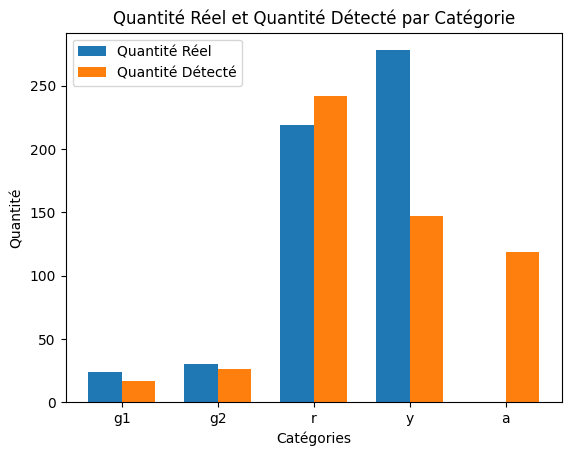

In [133]:
import pandas as pd
import numpy as np

labels = ["g1","g2","r","y","a"]

# Création d'un tableau vide pour stocker les résultats
result_table = np.zeros((2, len(labels)), dtype=int)

# Remplissage du tableau avec les données
for true, detected in zip(true_category, category_detection):
    true_index = labels.index(true)
    detected_index = labels.index(detected)
    result_table[0, true_index] += 1
    result_table[1, detected_index] += 1

# Création d'un DataFrame pandas
df = pd.DataFrame(result_table, columns=labels, index=["Quantité Réel", "Quantité Détecté"])

# Affichage du DataFrame
print("Tableau des quantités réel et détectés pour chaque catégorie :")
display(df)


# Création du plot
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, result_table[0], width, label='Quantité Réel')
rects2 = ax.bar(x + width/2, result_table[1], width, label='Quantité Détecté')

# Ajout des étiquettes, titres et légendes
ax.set_xlabel('Catégories')
ax.set_ylabel('Quantité')
ax.set_title('Quantité Réel et Quantité Détecté par Catégorie')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Affichage du plot
plt.show()


Tableau des quantités réel et détectés pour chaque valeur :


,200,100,50,20,10,5,2,1
Quantité Réel,30,24,50,94,134,93,57,69
Quantité Détecté,26,40,48,32,155,182,38,30


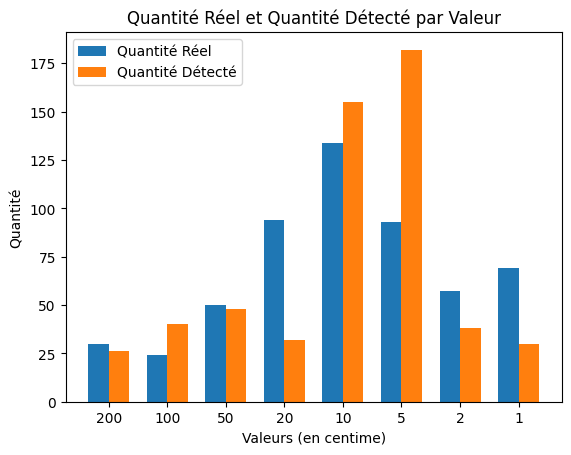

In [134]:
import pandas as pd
import numpy as np

labels = [200,100,50,20,10,5,2,1]

# Création d'un tableau vide pour stocker les résultats
result_table = np.zeros((2, len(labels)), dtype=int)

# Remplissage du tableau avec les données
for true, detected in zip(true_val, val_detection):
    true_index = labels.index(true)
    detected_index = labels.index(detected)
    result_table[0, true_index] += 1
    result_table[1, detected_index] += 1

# Création d'un DataFrame pandas
df = pd.DataFrame(result_table, columns=labels, index=["Quantité Réel", "Quantité Détecté"])

# Affichage du DataFrame
print("Tableau des quantités réel et détectés pour chaque valeur :")
display(df)


# Création du plot
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, result_table[0], width, label='Quantité Réel')
rects2 = ax.bar(x + width/2, result_table[1], width, label='Quantité Détecté')

# Ajout des étiquettes, titres et légendes
ax.set_xlabel('Valeurs (en centime)')
ax.set_ylabel('Quantité')
ax.set_title('Quantité Réel et Quantité Détecté par Valeur')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Affichage du plot
plt.show()
